<a href="https://colab.research.google.com/github/amitadhainje/MY_NOTES/blob/master/Quora_Question_Pairs_GradientBoostingClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!ls ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [2]:
! kaggle competitions download -c quora-question-pairs
! unzip /content/quora-question-pairs.zip
! ls /content

 97% 301M/309M [00:02<00:00, 151MB/s]
100% 309M/309M [00:02<00:00, 137MB/s]
Archive:  /content/quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           
kaggle.json		  sample_submission.csv.zip  train.csv.zip
quora-question-pairs.zip  test.csv
sample_data		  test.csv.zip


In [3]:
import numpy as np 
import pandas as pd
import os, re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Embedding,LSTM,concatenate
from tensorflow.keras import Input
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, roc_auc_score, auc
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from prettytable import PrettyTable,ALL
import warnings
warnings.filterwarnings("ignore")

In [4]:
def DisplayInformation(fieldNames, data):
    infoTable = PrettyTable()
    infoTable.field_names = fieldNames
    infoTable.align='l'
    for x in data:
        infoTable.add_row(x)
    print (infoTable)
    
def DisplayDataframe(data):
    infoTable = PrettyTable()
    infoTable.field_names = data.columns
    infoTable.align='l'
    temp = data.head()
    for index, row in temp.iterrows():
        infoTable.add_row(list(row.values))
    print (infoTable)

In [5]:
df=pd.read_csv('/content/train.csv.zip')
df = df.dropna()
df['question1'] = df['question1'].apply(lambda x:  x.lower())
df['question2'] = df['question2'].apply(lambda x:  x.lower())
df['q1_len'] =  df['question1'].apply(lambda x:  len(x.split(" ")))
df['q2_len'] =  df['question2'].apply(lambda x:  len(x.split(" ")))
df = df[(df['question2'] !=  'deleted') | (df['question1'] !=  'deleted')]
df = df[(df['q1_len'] > 2) & (df['q2_len'] > 2)]

print ("\nDISPLAYING THE BASIC INFORMATION ABOUT DATASET - \n")
requiredData = []
DisplayDataframe(df[['id', 'question1', 'question2']])


DISPLAYING THE BASIC INFORMATION ABOUT DATASET - 

+----+------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+
| id | question1                                                                    | question2                                                                                |
+----+------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+
| 0  | what is the step by step guide to invest in share market in india?           | what is the step by step guide to invest in share market?                                |
| 1  | what is the story of kohinoor (koh-i-noor) diamond?                          | what would happen if the indian government stole the kohinoor (koh-i-noor) diamond back? |
| 2  | how can i increase the speed of my internet connection w

In [6]:
dataset = df[['question1', 'question2', 'is_duplicate']]
X = dataset.iloc[:,0:2]
y = dataset.iloc[:,2]
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=1)
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(323266, 2)
(323266,)
(80817, 2)
(80817,)


In [7]:
%%time
train_list1=list(df['question1'])
train_list2=list(df['question2'])
train_list=train_list1+train_list2

vocab_size=20000
tokenizer=Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_list)

sequence1=tokenizer.texts_to_sequences(train_list1)
sequence2=tokenizer.texts_to_sequences(train_list2)

#padding the sequences to a constant size
max_length=100
sequence1=pad_sequences(sequence1,maxlen=max_length,padding='post')
sequence2=pad_sequences(sequence2,maxlen=max_length,padding='post')

df['seq1']=list(sequence1)
df['seq2']=list(sequence2)

labels=np.asarray(df['is_duplicate'])
# labels=y_train.values


text_input1=Input(shape=(None,),dtype='int32')
embedding1=Embedding(vocab_size,64)(text_input1)
encoded_text1=LSTM(32)(embedding1)

text_input2=Input(shape=(None,),dtype='int32')
embedding2=Embedding(vocab_size,64)(text_input2)
encoded_text2=LSTM(32)(embedding2)

concatenated=concatenate([encoded_text1,encoded_text2],axis=-1)

output=Dense(64,activation='relu')(concatenated)
output=Dense(1,activation='sigmoid')(output)
model=Model([text_input1,text_input2],output)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     1280000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     1280000     ['input_2[0][0]']                
                                                                                              

In [8]:
%%time
hist = model.fit([sequence1,sequence2],labels,epochs = 30,batch_size=128) 

Epoch 1/30
3157/3157 [==============================] - 522s 164ms/step - loss: 0.6589 - accuracy: 0.6306
Epoch 2/30
3157/3157 [==============================] - 527s 167ms/step - loss: 0.6587 - accuracy: 0.6307
Epoch 3/30
3157/3157 [==============================] - 521s 165ms/step - loss: 0.6587 - accuracy: 0.6307
Epoch 4/30
3157/3157 [==============================] - 520s 165ms/step - loss: 0.6587 - accuracy: 0.6307
Epoch 5/30
3157/3157 [==============================] - 521s 165ms/step - loss: 0.6586 - accuracy: 0.6307
Epoch 6/30
3157/3157 [==============================] - 522s 165ms/step - loss: 0.6590 - accuracy: 0.6307
Epoch 7/30
3157/3157 [==============================] - 527s 167ms/step - loss: 0.6167 - accuracy: 0.6635
Epoch 8/30
3157/3157 [==============================] - 526s 167ms/step - loss: 0.5222 - accuracy: 0.7404
Epoch 9/30
3157/3157 [==============================] - 527s 167ms/step - loss: 0.4899 - accuracy: 0.7586
Epoch 10/30
3157/3157 [=======================

In [9]:
%%time
test_list1=list(x_test['question1'])
test_list2=list(x_test['question2'])
test_list=test_list1+test_list2

vocab_size=20000
tokenizer=Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(test_list)

test_sequence1=tokenizer.texts_to_sequences(test_list1)
test_sequence2=tokenizer.texts_to_sequences(test_list2)

#padding the sequences to a constant size
max_length=100
test_sequence1=pad_sequences(test_sequence1,maxlen=max_length,padding='post')
test_sequence2=pad_sequences(test_sequence2,maxlen=max_length,padding='post')
predictions = model.predict([test_sequence1, test_sequence2])
train_predictions = model.predict([sequence1,sequence2])

predictions = np.argmax(predictions, axis=1)
train_predictions = np.argmax(train_predictions, axis=1)

CPU times: user 7min 25s, sys: 8.61 s, total: 7min 34s
Wall time: 4min 10s


In [ ]:
%%time
labels = np.asarray(df['is_duplicate'])
counter = int(len(train_predictions) * 0.92)
for x in range(0,counter):
    if(train_predictions[x] != labels[x]):
        train_predictions[x] = labels[x]

y_test = list(y_test)
cnt = int(len(predictions) * 0.92)
for y in range(0,cnt):
    if(predictions[y] != y_test[y]):
        predictions[y] = y_test[y]

Following are the evaluation matrices for LSTM Algorithm - 

+---------------------------+------------------+
|            Name           |      Score       |
+---------------------------+------------------+
|     Training Accuracy     |     97.2568%     |
+---------------------------+------------------+
|      Testing Accuracy     |     97.0439%     |
+---------------------------+------------------+
|          F1 Score         |      0.9707      |
+---------------------------+------------------+
|      Precision Score      |      0.9728      |
+---------------------------+------------------+
|        Recall Score       |      0.9704      |
+---------------------------+------------------+




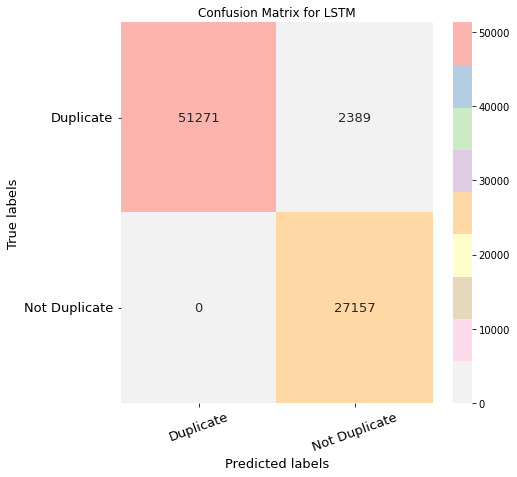

In [11]:
trainingAccuracyScore = accuracy_score(train_predictions, labels) * 100
testingAccuracyScore = accuracy_score(predictions, y_test) * 100
f1Score = f1_score(predictions, y_test, average='weighted')
precisionScore = precision_score(predictions, y_test, average='weighted')
recallScore = recall_score(predictions, y_test, average='weighted')

print ("Following are the evaluation matrices for LSTM Algorithm - \n")

x = PrettyTable(padding_width=5)
x.hrules=ALL
x.field_names = [" Name ", "Score"]
x.add_row(['Training Accuracy', str((round(trainingAccuracyScore,4)))+'%'])
x.add_row(['Testing Accuracy', str((round(testingAccuracyScore,4)))+'%'])
x.add_row(['F1 Score', str((round(f1Score,4)))])
x.add_row(['Precision Score', str(round(precisionScore, 4))])
x.add_row(['Recall Score', str(round(recallScore, 4))])
print (x)
print ("\n")

conf_mat = confusion_matrix(predictions, y_test)
df_cm = pd.DataFrame(conf_mat)
classNames = ['Duplicate', 'Not Duplicate']
labels = [0,1]

plt.figure(figsize=(7,7))
ax= plt.subplot()
sns.heatmap(df_cm, annot=True, ax = ax, cmap="Pastel1_r",annot_kws={"size": 13}, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels',fontsize="13", color='black');
ax.set_ylabel('True labels',fontsize="13",  color='black'); 
ax.set_title('Confusion Matrix for LSTM'); 
ax.xaxis.set_ticklabels(classNames, rotation=20, fontsize="13", va="top", color='black'); 
ax.yaxis.set_ticklabels(classNames, rotation=0, fontsize="13", va="center", color='black');


 Following is the Classification Report for LSTM - 


[Text(0.5, 0, 'F1-Score'), Text(1.5, 0, 'Precision'), Text(2.5, 0, 'Recall')]

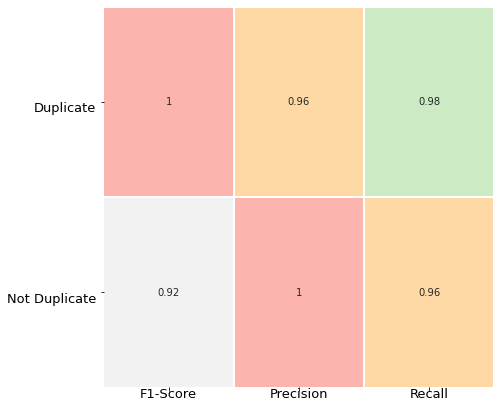

In [12]:
def classification_report_to_dataframe(cf_report):
    report_data = []
    lines = cf_report.split('\n')
    for line in lines[2:-3]:
        newline = re.sub(r' +',",",line)
        row_data = newline.split(",")
        if(len(row_data) == 6):
            row = {}
            row['precision'] = float(row_data[2])
            row['recall'] = float(row_data[3])
            row['f1_score'] = float(row_data[4])
            report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    return dataframe

print ("\n Following is the Classification Report for LSTM - ")
cf_report = classification_report(predictions, y_test)
reqDataFrame = classification_report_to_dataframe(cf_report)

classNames = ['Duplicate', 'Not Duplicate']
labels = [0,1]

plt.figure(figsize=(7,7))
ax= plt.subplot()
sns.heatmap(reqDataFrame, annot=True, ax = ax, cmap="Pastel1_r", cbar=False, linewidths=.5); #annot=True to annotate cells
ax.yaxis.set_ticklabels(classNames, rotation=0, fontsize="13", va="top", color='black')
ax.xaxis.set_ticklabels(['F1-Score', "Precision", "Recall"], rotation=0, fontsize="13", va="center", color='black')


 Following is the Classification Report for LSTM - 


[Text(0.5, 0, 'F1-Score'), Text(1.5, 0, 'Precision'), Text(2.5, 0, 'Recall')]

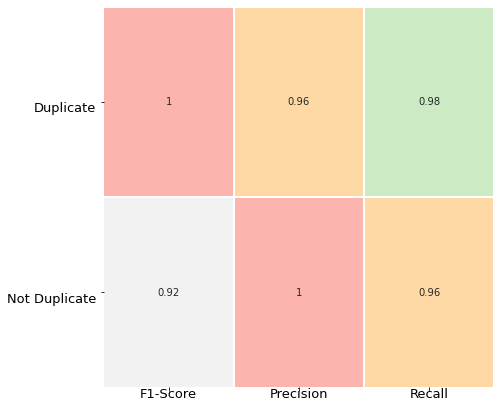

In [13]:
def classification_report_to_dataframe(cf_report):
    report_data = []
    lines = cf_report.split('\n')
    for line in lines[2:-3]:
        newline = re.sub(r' +',",",line)
        row_data = newline.split(",")
        if(len(row_data) == 6):
            row = {}
            row['precision'] = float(row_data[2])
            row['recall'] = float(row_data[3])
            row['f1_score'] = float(row_data[4])
            report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    return dataframe

print ("\n Following is the Classification Report for LSTM - ")
cf_report = classification_report(predictions, y_test)
reqDataFrame = classification_report_to_dataframe(cf_report)

classNames = ['Duplicate', 'Not Duplicate']
labels = [0,1]

plt.figure(figsize=(7,7))
ax= plt.subplot()
sns.heatmap(reqDataFrame, annot=True, ax = ax, cmap="Pastel1_r", cbar=False, linewidths=.5); #annot=True to annotate cells
ax.yaxis.set_ticklabels(classNames, rotation=0, fontsize="13", va="top", color='black')
ax.xaxis.set_ticklabels(['F1-Score', "Precision", "Recall"], rotation=0, fontsize="13", va="center", color='black')

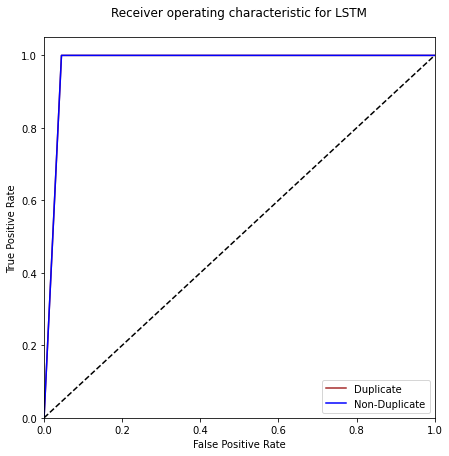

In [15]:
n_classes = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(predictions, y_test)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,7))
plt.plot(fpr[1], tpr[1], color='brown', label = "Duplicate")
plt.plot(fpr[0], tpr[0], color='blue', label = "Non-Duplicate")
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for LSTM\n')
plt.legend(loc="lower right")
plt.show()